In [464]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats
from datetime import datetime
from tqdm import tqdm
import time


warnings.simplefilter(action='ignore', category=UserWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [465]:
year = pd.read_csv('/opt/ml/input/data/train/years.tsv', sep='\t')
writer = pd.read_csv('/opt/ml/input/data/train/writers.tsv', sep='\t')
title = pd.read_csv('/opt/ml/input/data/train/titles.tsv', sep='\t')
genre = pd.read_csv('/opt/ml/input/data/train/genres.tsv', sep='\t')
director = pd.read_csv('/opt/ml/input/data/train/directors.tsv', sep='\t')

rating = pd.read_csv('/opt/ml/input/data/train/train_ratings.csv')

In [466]:
datas = [rating, year, writer, title, genre, director]
for i in datas:
    print("{} 데이터의 item의 갯수는 {}".format(i.columns[1],i.item.nunique()))
    
# 감독과 작가가 누락된 경우 확인, 개봉년도는 소수 누락된 경우 확인 
print("------------------------------------------------------------")

datas = [rating, year, writer, title, genre, director]
for i in datas:
    print("{} 데이터의 행의 갯수는 {}".format(i.columns[1],i.shape[0]))
    
# 한 item에 대해서 개봉일이나 타이틀은 당연하게도 unique하지만, 나머지는 중복 존재~ 
# 추가적으로 item에 대한 콜드 스타트는 전혀 존재하지 않는 상황 ~ 즉 모든 item이 한번 이상은 관측 되었다는 것

item 데이터의 item의 갯수는 6807
year 데이터의 item의 갯수는 6799
writer 데이터의 item의 갯수는 5648
title 데이터의 item의 갯수는 6807
genre 데이터의 item의 갯수는 6807
director 데이터의 item의 갯수는 5503
------------------------------------------------------------
item 데이터의 행의 갯수는 5154471
year 데이터의 행의 갯수는 6799
writer 데이터의 행의 갯수는 11306
title 데이터의 행의 갯수는 6807
genre 데이터의 행의 갯수는 15933
director 데이터의 행의 갯수는 5905


## Rating

### 시청기록에 대한 Describe

평균 시청 횟수 : 164.36450892857144 /// 최소 시청 횟수 : 16 /// 최대 시청 횟수 : 2912 /// 분포 : 150.00910740110473 


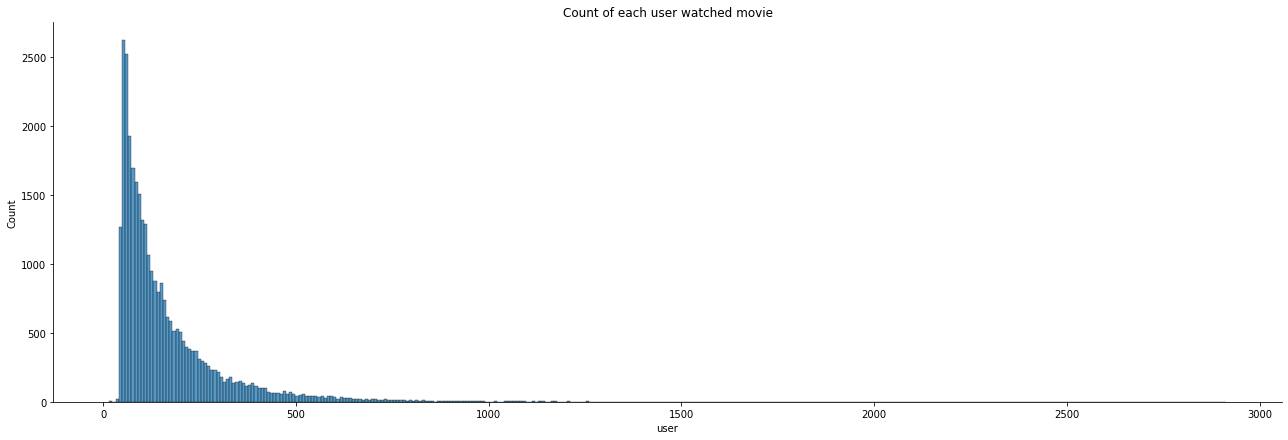

In [467]:
counts = rating.user.value_counts().reset_index()
sns.displot(counts.user, height = 6, aspect = 3).set(title='Count of each user watched movie')
print("평균 시청 횟수 : {} /// 최소 시청 횟수 : {} /// 최대 시청 횟수 : {} /// 분포 : {} ".format(counts.user.mean(),counts.user.min(),counts.user.max(),counts.user.std()))

# 꽤나 Outlier들이 심하게 존재한다고 생각
# top 10인 것과 rating 데이터 고의누락을 생각하면, +9개는 될듯

평균 시청 횟수 : 757.2309387395328 /// 최소 시청 횟수 : 27 /// 최대 시청 횟수 : 19699 /// 분포 : 1682.9730895249875 


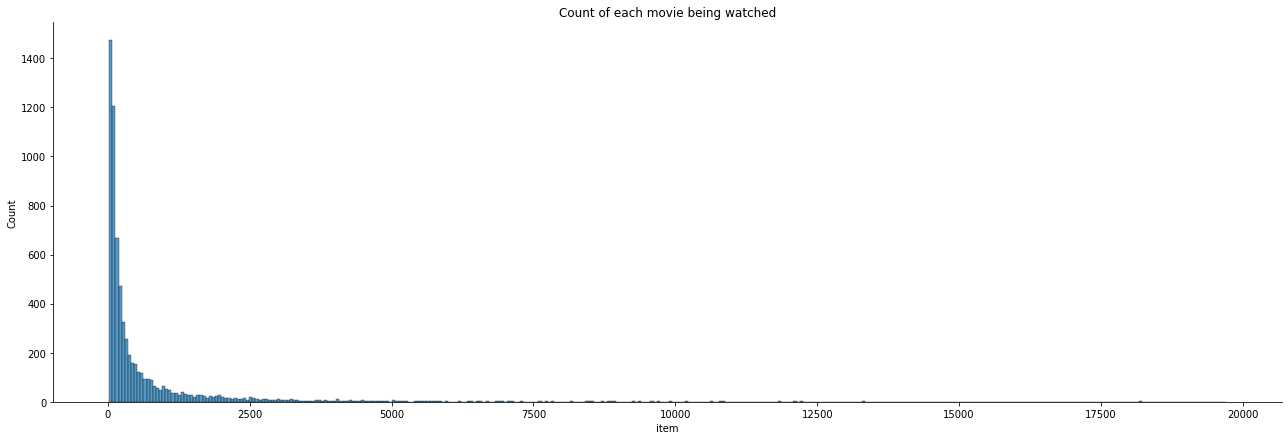

In [468]:
watchs = rating.item.value_counts().reset_index()
sns.displot(watchs.item, height = 6, aspect = 3).set(title='Count of each movie being watched')
print("평균 시청 횟수 : {} /// 최소 시청 횟수 : {} /// 최대 시청 횟수 : {} /// 분포 : {} ".format(watchs.item.mean(),watchs.item.min(),watchs.item.max(),watchs.item.std()))

# 유저별 시청 횟수와 마찬가지로 영화별로 시청 횟수 역시, 상당히 outlier가 많은 편

In [469]:
# time의 시계열 요소 추출
rating['year'] = rating['time'].apply(lambda x : datetime.fromtimestamp(x).year)
rating['month'] = rating['time'].apply(lambda x : datetime.fromtimestamp(x).month)
rating['hour'] = rating['time'].apply(lambda x : datetime.fromtimestamp(x).hour)

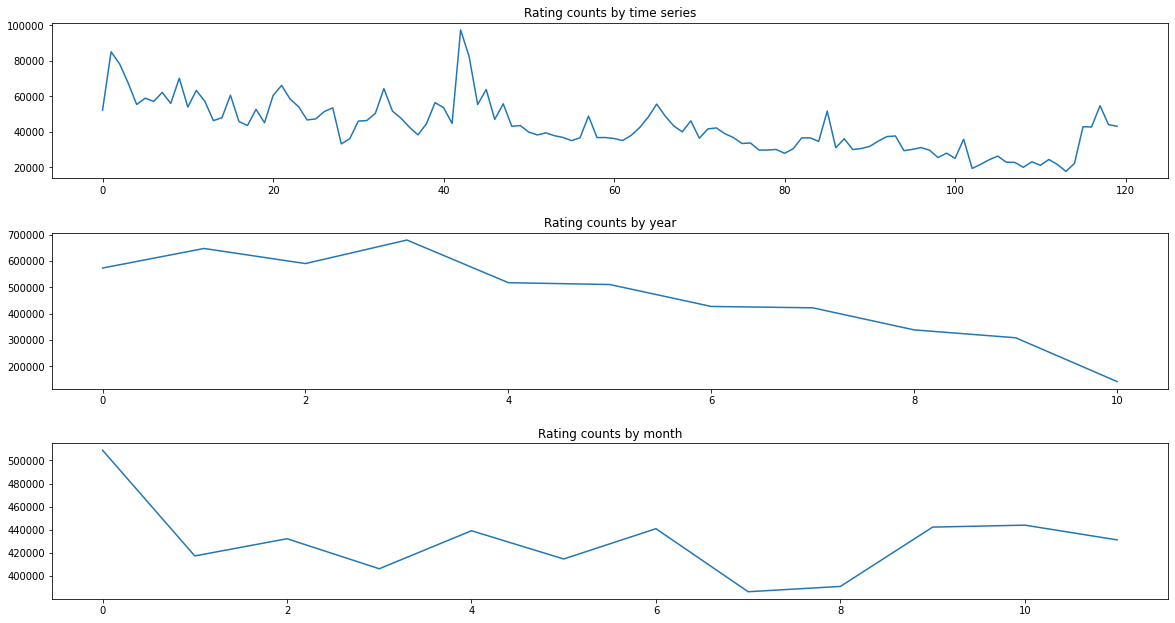

In [470]:
fig, (axes1,axes2,axes3) = plt.subplots(3,1,figsize=(20,10))
axes1.plot(rating[['year','month']].value_counts().reset_index().sort_values(by=['year','month']).reset_index(drop=True)[0])
axes1.set_title('Rating counts by time series')

axes2.plot(rating[['year']].value_counts().reset_index().sort_values(by='year').reset_index(drop=True)[0])
axes2.set_title('Rating counts by year')

axes3.plot(rating[['month']].value_counts().reset_index().sort_values(by='month').reset_index(drop=True)[0])
axes3.set_title('Rating counts by month')


plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

# 전반적인 회귀선은 우하향이라고 생각
# year를 봐도 우향한하는 형태를 볼 수 있음
# 월별로 볼 경우엔, 겨울에 비교적 더 많은 rating액션이 발생하는것을 확인 가능 ~ 다만 그래프로 봐서 그렇지 수치적으로는 그렇게 큰 차이는 아님

Text(0.5, 1.0, 'Rating counts by hour')

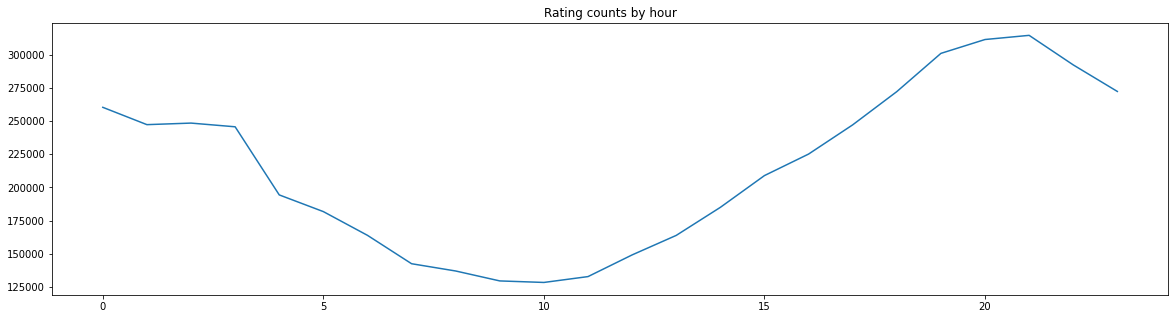

In [471]:
fig, axes = plt.subplots(1,1,figsize=(20,5))
plt.plot(rating[['hour']].value_counts().reset_index().sort_values(by='hour').reset_index(drop=True)[0])
axes.set_title('Rating counts by hour')

# 저녁과 밤 시간에 확실히 rating이 많이 count되는 중 ~ month와 달리 수치적으로도 확실히 차이가 나는 편

### 시청기록에 대한 Time lag

In [472]:
'''
rating['time_diff'] = 0
for i in tqdm(range(rating.shape[0]-1)):
    if rating.user[i+1] == rating.user[i]:
        rating.time_diff[i] = round(((datetime.fromtimestamp(rating.time[i+1]) - datetime.fromtimestamp(rating.time[i])).total_seconds()/60))
rating.to_csv('/opt/ml/input/data/train/train_ratings_timediff.csv')
'''
# 람다 사용할수 있게 수정이 될려나
rating = pd.read_csv('/opt/ml/input/data/train/train_ratings_timediff.csv')
# 현재 rating은 유저별로 time순으로 sort되어 있는 경우 
# 그렇기에 다음에 본 item과의 diff를 계산해서, 현재 item을 보는 순간과 다음 item을 보는 순간의 time_lag를 구한다 ~ 이상치 확인 
# 즉 해당 item을 실제로 본 시간 + a 
# 물론 시간 차이가 난다고 해서 진짜 봣는지 안봣는지는 여전히 미정이지만 그래도 time_lag이 1인 것고과 300인것의 차이는 있다고 생각
        

In [473]:
print("직전 item과 시청간격이 120분미만인 경우 : {}개".format(rating[rating['time_diff']<120].shape[0]))
print("직전 item과 시청간격이 120분이상인 경우 : {}개".format(rating[rating['time_diff']>=120].shape[0]))
# 아무리 연속으로 본다고 해도 하나의 러닝타임은 지나야 하니까...
# 10%의 데이터만이 그러한 간격을 갖는다

직전 item과 시청간격이 120분미만인 경우 : 4667776개
직전 item과 시청간격이 120분이상인 경우 : 486695개


평균 시청 횟수 : 22.302951150215378 /// 최소 시청 횟수 : 1 /// 최대 시청 횟수 : 833 /// 분포 : 53.287947446075606 


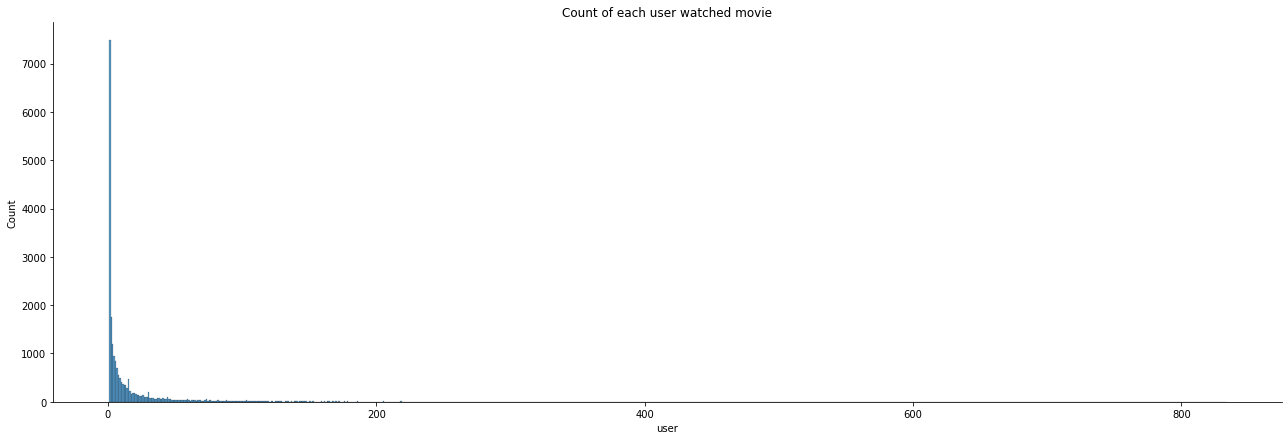

In [474]:
# 유의미할 것으로 예상되는 애들에 대해 다시 위의 시각화를 진행하면
rating_new = rating[rating['time_diff']>=120]

counts = rating_new.user.value_counts().reset_index()
sns.displot(counts.user, height = 6, aspect = 3).set(title='Count of each user watched movie')
print("평균 시청 횟수 : {} /// 최소 시청 횟수 : {} /// 최대 시청 횟수 : {} /// 분포 : {} ".format(counts.user.mean(),counts.user.min(),counts.user.max(),counts.user.std()))

# 확실히 더 sparse 해진 듯


평균 시청 횟수 : 71.58332107662892 /// 최소 시청 횟수 : 1 /// 최대 시청 횟수 : 1099 /// 분포 : 106.94283388254938 


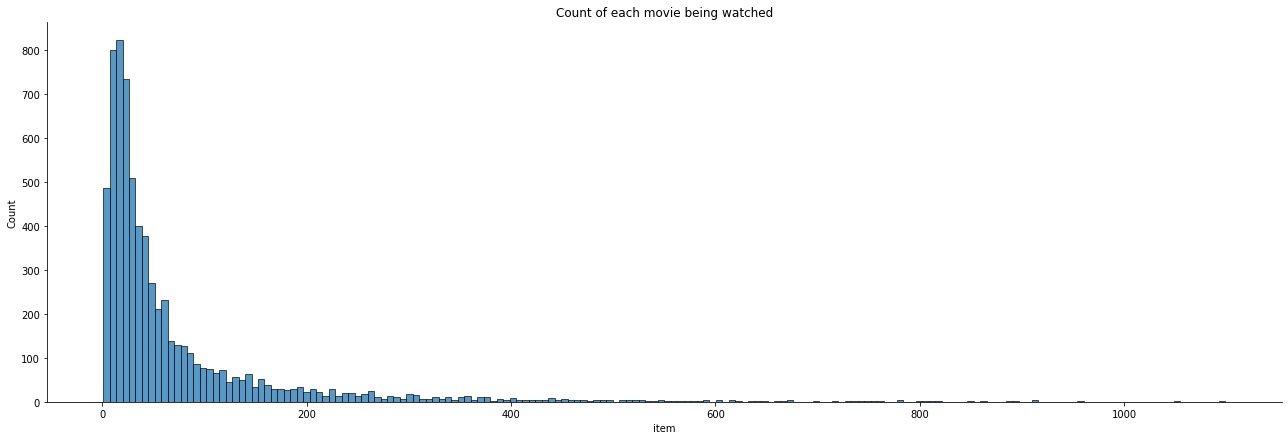

In [475]:
watchs = rating_new.item.value_counts().reset_index()
sns.displot(watchs.item, height = 6, aspect = 3).set(title='Count of each movie being watched')
print("평균 시청 횟수 : {} /// 최소 시청 횟수 : {} /// 최대 시청 횟수 : {} /// 분포 : {} ".format(watchs.item.mean(),watchs.item.min(),watchs.item.max(),watchs.item.std()))

# 오히려 덜 sparse해짐

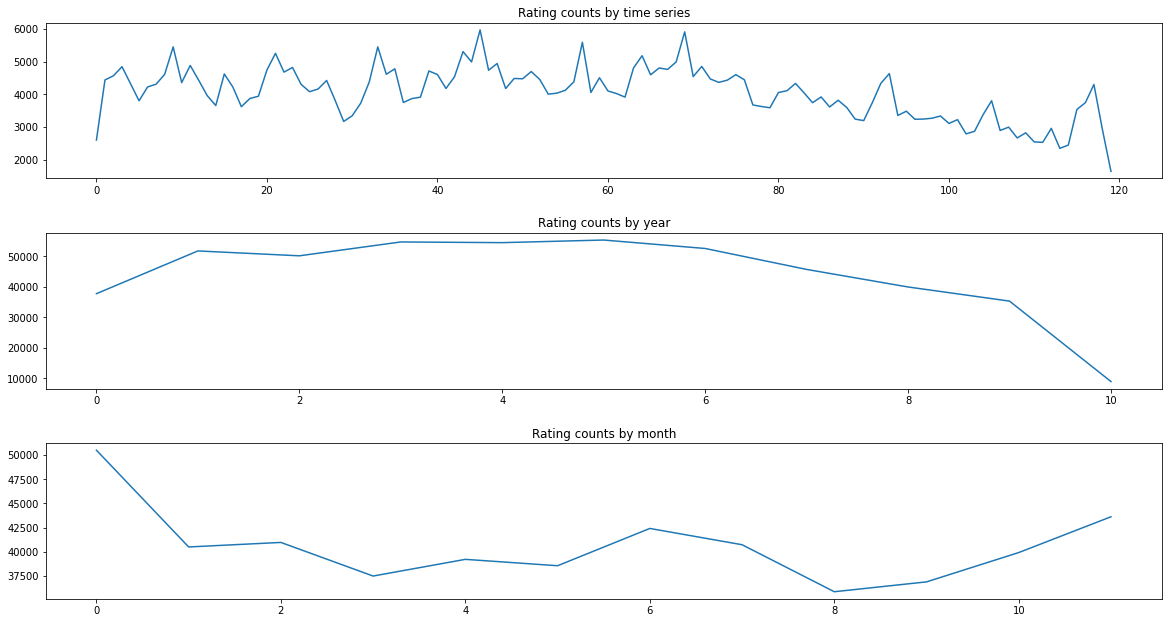

In [476]:
fig, (axes1,axes2,axes3) = plt.subplots(3,1,figsize=(20,10))
axes1.plot(rating_new[['year','month']].value_counts().reset_index().sort_values(by=['year','month']).reset_index(drop=True)[0])
axes1.set_title('Rating counts by time series')

axes2.plot(rating_new[['year']].value_counts().reset_index().sort_values(by='year').reset_index(drop=True)[0])
axes2.set_title('Rating counts by year')

axes3.plot(rating_new[['month']].value_counts().reset_index().sort_values(by='month').reset_index(drop=True)[0])
axes3.set_title('Rating counts by month')


plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

# 월별은 유사하게 나타나지만, 년도별의 약간의 차이가 있음 ~ 완전히 우하향하지 않고 9년차쯤부터 급감 ~ 이는 아마 데이터 자체가 마지막년도에 기간이 짧아서

Text(0.5, 1.0, 'Rating counts by hour')

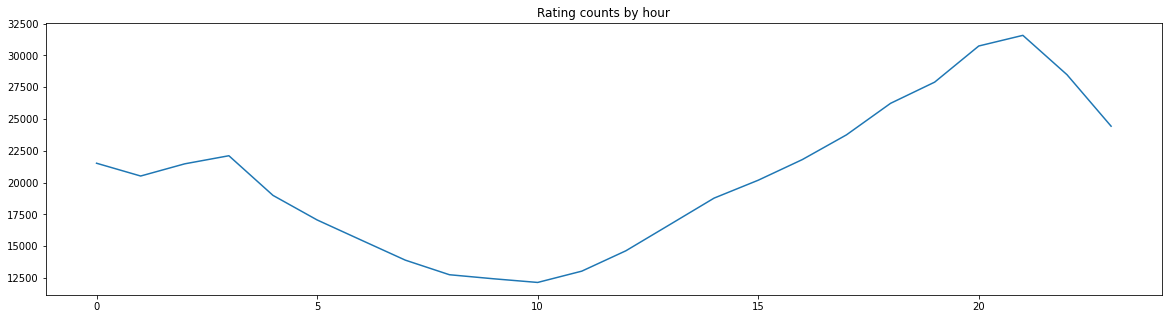

In [477]:
fig, axes = plt.subplots(1,1,figsize=(20,5))
plt.plot(rating_new[['hour']].value_counts().reset_index().sort_values(by='hour').reset_index(drop=True)[0])
axes.set_title('Rating counts by hour')

# 유사하나 새벽의 분포가 좀 줄어 들었다

## Genre

최대 한 item이 갖는 장르 수 : 10 /// item의 평균 장르 순 : 2.3406787130894666


Text(0.5, 1.0, 'Count of Genre')

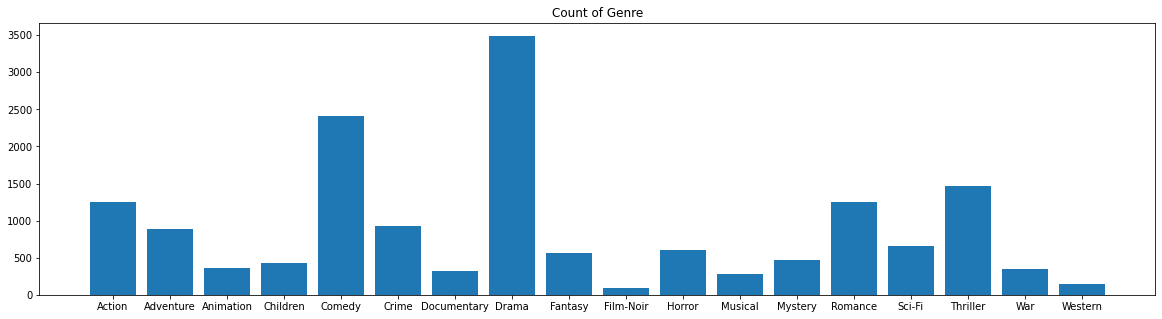

In [478]:
print("최대 한 item이 갖는 장르 수 : {} /// item의 평균 장르 순 : {}".format(genre.groupby('item').count().max()[0],genre.groupby('item').count().mean()[0]))

fig, axes = plt.subplots(1,1, figsize=(20,5))
plt.bar(genre.groupby('genre').count().index,genre.groupby('genre').count().item)
axes.set_title("Count of Genre")
# 개별 장르의 숫자, 단 중복여부만 확인
# 드라마와 코미디 가 제일 강세

### Genre 합치기 처리

In [479]:
for i in tqdm(range(1,genre.shape[0])):
    if genre.item[i] == genre.item[i-1]:
        genre.genre[i] = genre.genre[i-1] + "," + genre.genre[i]

genre_new = genre.loc[genre.item.drop_duplicates(keep='last').index].reset_index(drop=True)
genre_new['genre_num'] = genre_new['genre'].str.count(",")+1

# merge를 위해서 하나의 item 당 하나의 genre 묶음을 갖도록 설정, 추가적으로 장르 숫자추가
# 이때 아이템별로, genre 알파벳 별로 sort가 되어있기에 가능

  0%|          | 0/15932 [00:00<?, ?it/s]/tmp/ipykernel_15550/3675270836.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre.genre[i] = genre.genre[i-1] + "," + genre.genre[i]
100%|██████████| 15932/15932 [00:02<00:00, 5387.81it/s]


Text(0.5, 1.0, 'Count of Genre number of each item')

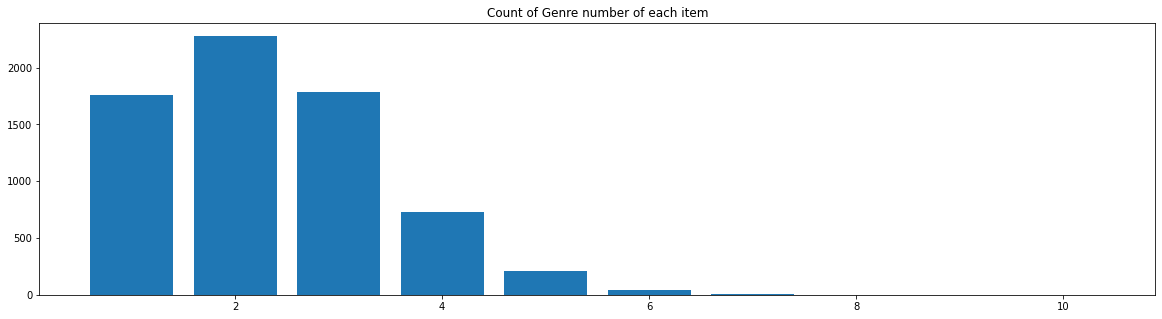

In [480]:
fig, axes = plt.subplots(1,1, figsize=(20,5))
plt.bar(genre_new.groupby('genre_num').count().index, genre_new.groupby('genre_num').count().item)
axes.set_title("Count of Genre number of each item")

# 1,2,3개의 장르를 보편적으로 갖는다

Text(0.5, 1.0, 'Count of Genre #1')

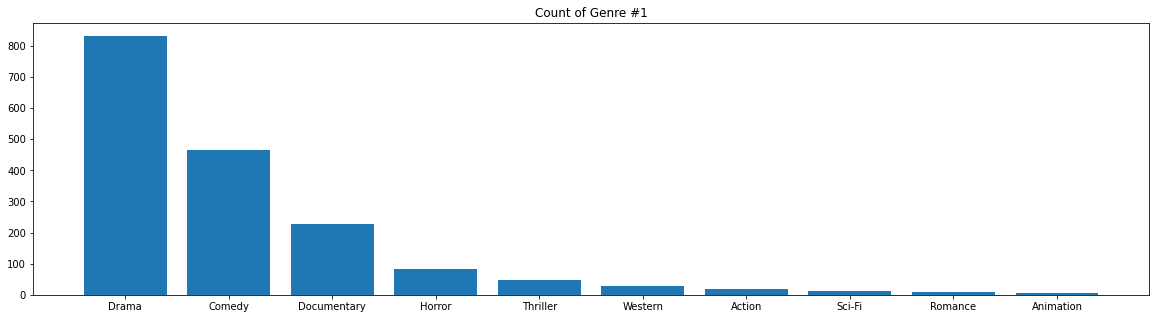

In [481]:
genre_new_1 = genre_new[genre_new['genre_num']==1]
genre_new_1 = genre_new_1.groupby('genre').count().sort_values(by='item', ascending=False).head(10)
fig, axes = plt.subplots(1,1, figsize=(20,5))
plt.bar(genre_new_1.index, genre_new_1.item)
axes.set_title("Count of Genre #1")

# 장르가 단일일경우 조합
# 드라마 코미디가 마찬가지로 강세, 독특하게도 다큐멘터리가 3위인데 아마 다른 장르와 섞이지 않아서

Text(0.5, 1.0, 'Count of Genre number of each item #2')

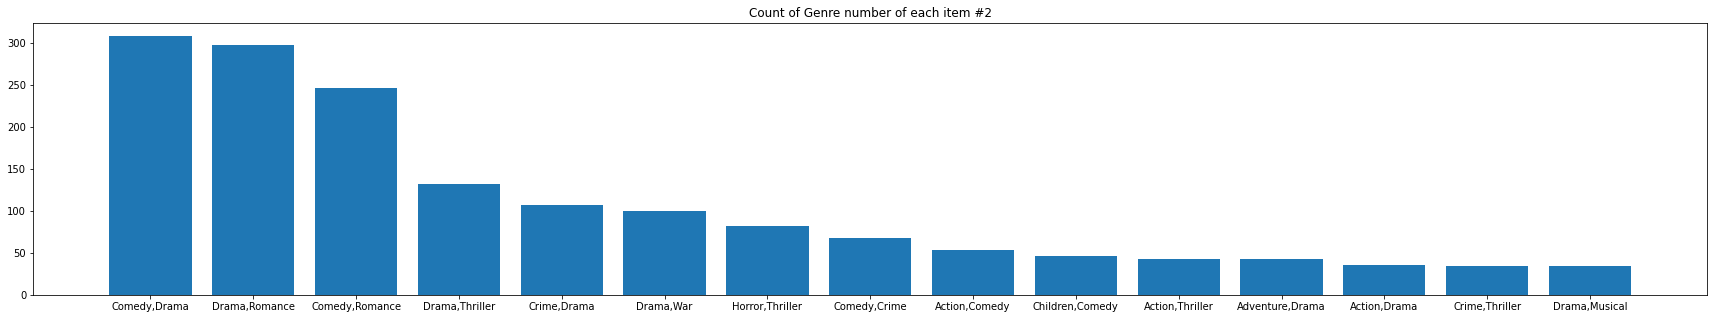

In [482]:
genre_new_2 = genre_new[genre_new['genre_num']==2]
genre_new_2 = genre_new_2.groupby('genre').count().sort_values(by='item', ascending=False).head(15)
fig, axes = plt.subplots(1,1, figsize=(30,5))
plt.bar(genre_new_2.index, genre_new_2.item)
axes.set_title("Count of Genre number of each item #2")

# 장르가 2개일 경우 상위 조합
# 드라마 코디미가 여전히 상위이며 로맨스가 3위

Text(0.5, 1.0, 'Count of Genre number of each item #3')

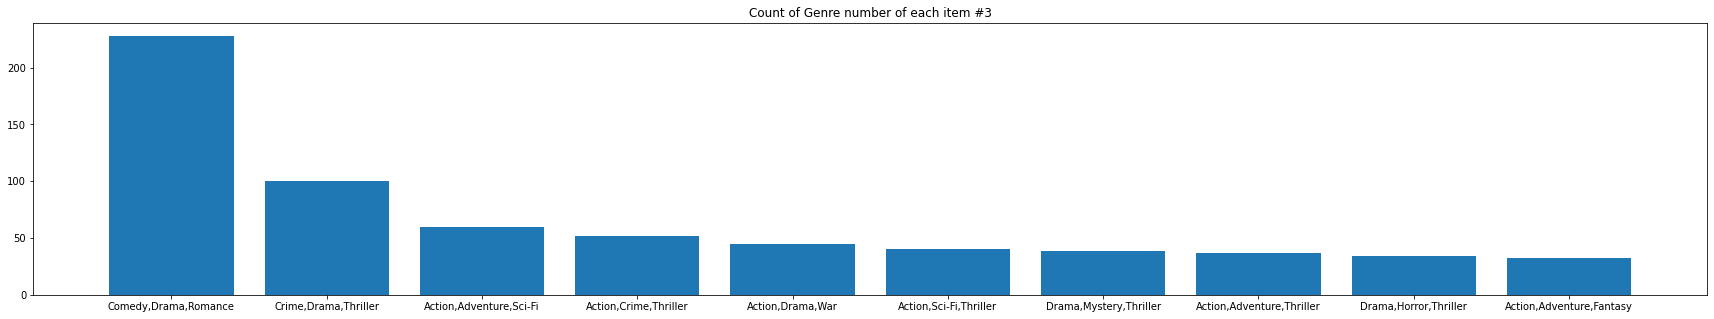

In [483]:
genre_new_3 = genre_new[genre_new['genre_num']==3]
genre_new_3 = genre_new_3.groupby('genre').count().sort_values(by='item', ascending=False).head(10)
fig, axes = plt.subplots(1,1, figsize=(30,5))
plt.bar(genre_new_3.index, genre_new_3.item)
axes.set_title("Count of Genre number of each item #3")

# 장르가 3개일 경우 상위 조합
# 드라마 코디미가 여전히 상위이며, 이제서야 하위에 액션 스릴러 등이 도출
# 종합적으로 보면, 액션 스릴러 등은 섞여서 장르 형성되나 코미디 드라마 로맨스 등은 1,2개로 대부분 형성되는 듯

## Director

In [484]:
dire = director.director.value_counts().reset_index()
print("평균 감독횟수 : {} /// 최소 감독횟수 : {} /// 최대 감독횟수 : {} /// 분포 : {} ".format(dire.director.mean(),dire.director.min(),dire.director.max(),dire.director.std()))

# 최소한 한 감독이 두 번 이상은 영화를 만들었고, 평균적으로 4번은 영화가 있음 ~ 상당히 outlier 존재
# 그러나 모든 item에 merge되는 경우는 아님 ~ 결측 존재

평균 감독횟수 : 4.406716417910448 /// 최소 감독횟수 : 2 /// 최대 감독횟수 : 44 /// 분포 : 3.6330303191214313 


In [485]:
director.item.value_counts().reset_index().item.max()

# 한 item에 여러 명의 감독이 붙어있는 경우도 확인이 가능
# director도 genre처럼 유의하게 묶을지는 이후 rating과 합친 total에서 확인 후 결정

14

## Title

In [486]:
title.title.value_counts()

# 사실 특별한 부분은 없고, 따지면 제일 item이 유니크한 값을 갖게 해주는 데이터셋
# title에 붙어있는 개봉년도는 따로 전처리 해줄 필요 확인 
# 이때 단 하나, 우주전쟁이 두개로 표기되는데, 확인필요


War of the Worlds (2005)                     2
Shawshank Redemption, The (1994)             1
Jay and Silent Bob Strike Back (2001)        1
Naked Gun 33 1/3: The Final Insult (1994)    1
Quantum of Solace (2008)                     1
                                            ..
Brigadoon (1954)                             1
Son, The (Le fils) (2002)                    1
Secret Life of Walter Mitty, The (1947)      1
Them! (1954)                                 1
Girl Next Door, The (1999)                   1
Name: title, Length: 6806, dtype: int64

In [487]:
genre[genre['item']==34048],genre[genre['item']==64997]

# 두 개의 아이디를 갖는 우주전쟁의 경우 genre도 다르게 가져가는 중

(       item                             genre
 1001  34048                            Action
 1002  34048                  Action,Adventure
 1003  34048           Action,Adventure,Sci-Fi
 1004  34048  Action,Adventure,Sci-Fi,Thriller,
        item          genre
 4735  64997         Action
 4736  64997  Action,Sci-Fi)

In [488]:
rating[rating['item']==34048],rating[rating['item']==64997]

# 후자의 것이 더 적게 보는 것으로 보아 그냥 전자의 것으로 통합 시키는 것이 나을듯 ~ 우선 나중에

(         Unnamed: 0    user   item        time  year  month  hour  time_diff
 126             126      11  34048  1230788489  2009      1     5          0
 5630           5630     208  34048  1157583328  2006      9    22      51997
 7675           7675     258  34048  1221520795  2008      9    23          0
 11320         11320     367  34048  1120865002  2005      7    23       8861
 12619         12619     388  34048  1174643516  2007      3     9         17
 ...             ...     ...    ...         ...   ...    ...   ...        ...
 5150174     5150174  138404  34048  1138010617  2006      1    10          0
 5150984     5150984  138414  34048  1386706180  2013     12    20      10958
 5152924     5152924  138456  34048  1183783639  2007      7     4          0
 5153574     5153574  138472  34048  1194041076  2007     11    22          2
 5154459     5154459  138493  34048  1258390758  2009     11    16          1
 
 [3022 rows x 8 columns],
          Unnamed: 0    user   item 

## Writer

In [489]:
# 기본적으로, 모든 item에 대해 대응하는 writer가 전부 있는 것은 아니지만 데이터의 크기를 생각해보면 상당히 아이템별로 중복이 많을 것으로 예측

wr = writer.writer.value_counts().reset_index()
print("평균 작가횟수 : {} /// 최소 작가횟수 : {} /// 최대 작가횟수 : {} /// 분포 : {} ".format(wr.writer.mean(),wr.writer.min(),wr.writer.max(),wr.writer.std()))

# 못해도 2번의 작가짓을 하며, 감독과 유사하게 40회 이상의 작가짓을 하는 것으로 보인다


평균 작가횟수 : 3.7825359652057546 /// 최소 작가횟수 : 2 /// 최대 작가횟수 : 47 /// 분포 : 2.993782511701665 


In [490]:
wr = writer.item.value_counts().reset_index()
print("평균 작가수 : {} /// 최소 작가수 : {} /// 최대 작가수 : {} /// 분포 : {} ".format(wr.item.mean(),wr.item.min(),wr.item.max(),wr.item.std()))

# 이렇듯, 유니크한 작가수도 item보다 적은데, 평균적으로 두명의작가를 두기에 item에 대한 결측이 발생
# 이때 감독과 마찬가지로 사용할지는 total에서 고려 ~ 그러나 감독보다도 덜 유의할 듯 ~ 감독은 봐도 각본을 보지는 않아서 진짜 마니아 아니면 모르니까
# but 작가의 성향이라는 것이 item에 반영될지도 

평균 작가수 : 2.001770538243626 /// 최소 작가수 : 1 /// 최대 작가수 : 24 /// 분포 : 1.5468586843593697 


## Year

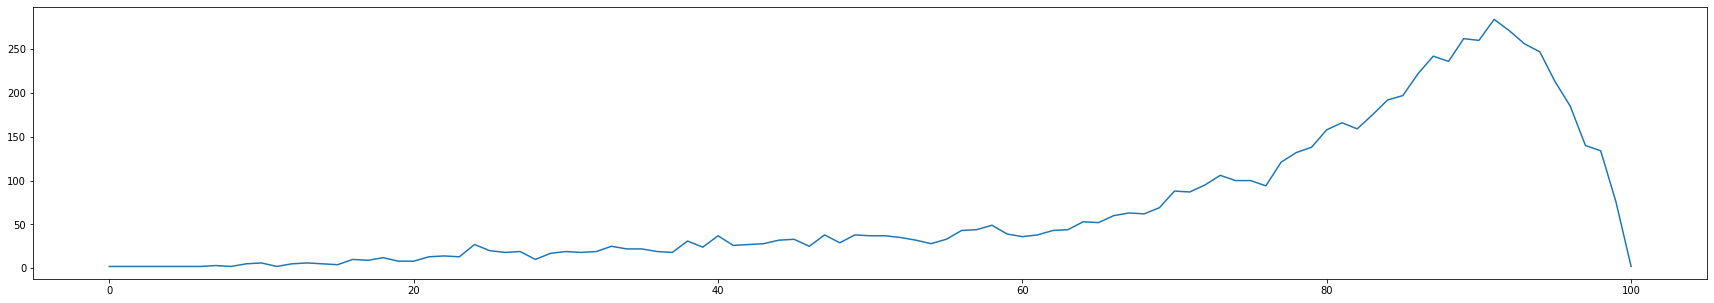

In [556]:
fig, axes = plt.subplots(1,1, figsize=(30,5))
plt.plot(year.year.value_counts().sort_index().reset_index().year)
# 특별한 것은 없으며 모든 영화가 상영년도가 있는 것은 아니지만 결측치의 경우 title에서 추출이 가능하다
# 이때 방영년도와 타이틀의 제작년도가 동일하지 않을수도? ~  재상영등의 이유

# 당연하게도 최근으로 들어올수록 item의 숫자는 커지고 2015년도엔 단 2개, 아마 최근에 꺾이는 이유는 극장이 아닌 ott의 rating이라 다소 늦게 올라오는 듯?

## Total

### Time lag 고려 안하고

In [492]:
d_ = pd.merge(rating, title, on='item', how='left')
d_1 = pd.merge(d_, genre_new, on='item', how='left')
data = pd.merge(d_1, year, on='item', how='left')

# 우선 감독와 작가는 제외
data= data[['user', 'item', 'title','year_y','genre','year_x', 'month', 'hour','time_diff',]]
data.columns = ['user', 'item', 'title','madeat','genre','year', 'month', 'hour','time_diff']

In [493]:
data.loc[data['madeat'].isnull()].nunique()
# 현재 제작년도에 대해서만 결측 존재 ~ 이때 단 8개에 대해서만 결측 존재
#  그냥 각 year에 해당 결측치 채워주는 것으로 ~ 

data_ = pd.DataFrame({'item':[6987,   3310,   7243,   8511,  32898,   7065, 119145,   6988], 'year':[1920,1921,1916,1917,1902,1915,2015,1919]})
year = pd.concat([year,data_])
year.year = year.year.apply(lambda x : int(x))

In [494]:
d_ = pd.merge(rating, title, on='item', how='left')
d_1 = pd.merge(d_, genre_new, on='item', how='left')
data = pd.merge(d_1, year, on='item', how='left')

# 우선 감독와 작가는 제외
data= data[['user', 'item', 'title','year_y','genre','genre_num','time','year_x', 'month', 'hour','time_diff']]
data.columns = ['user', 'item', 'title','madeat','genre','genre_num','time','year', 'month', 'hour','time_diff']
# 재실행f


In [495]:
data.isnull().sum()

user         0
item         0
title        0
madeat       0
genre        0
genre_num    0
time         0
year         0
month        0
hour         0
time_diff    0
dtype: int64

Text(0.5, 1.0, 'Made at with real rating')

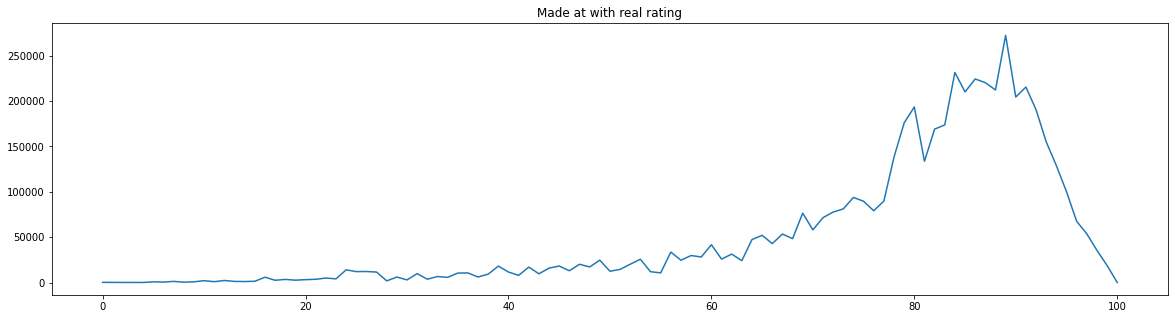

In [496]:
fig, axes1= plt.subplots(1,1,figsize=(20,5))
axes1.plot(data[['madeat']].value_counts().reset_index().sort_values(by='madeat').reset_index(drop=True)[0])
axes1.set_title('Made at with real rating')

# 실제 제작년도가 최근일수록 더더욱 보는 경향성이 있음
# rating의 구간이 2005-2015임을 감안했을 때, 당연한 결과 
# 영화의 제작년도는 1915부터 2015까지임을 감안했을 때, 당연한 결과 

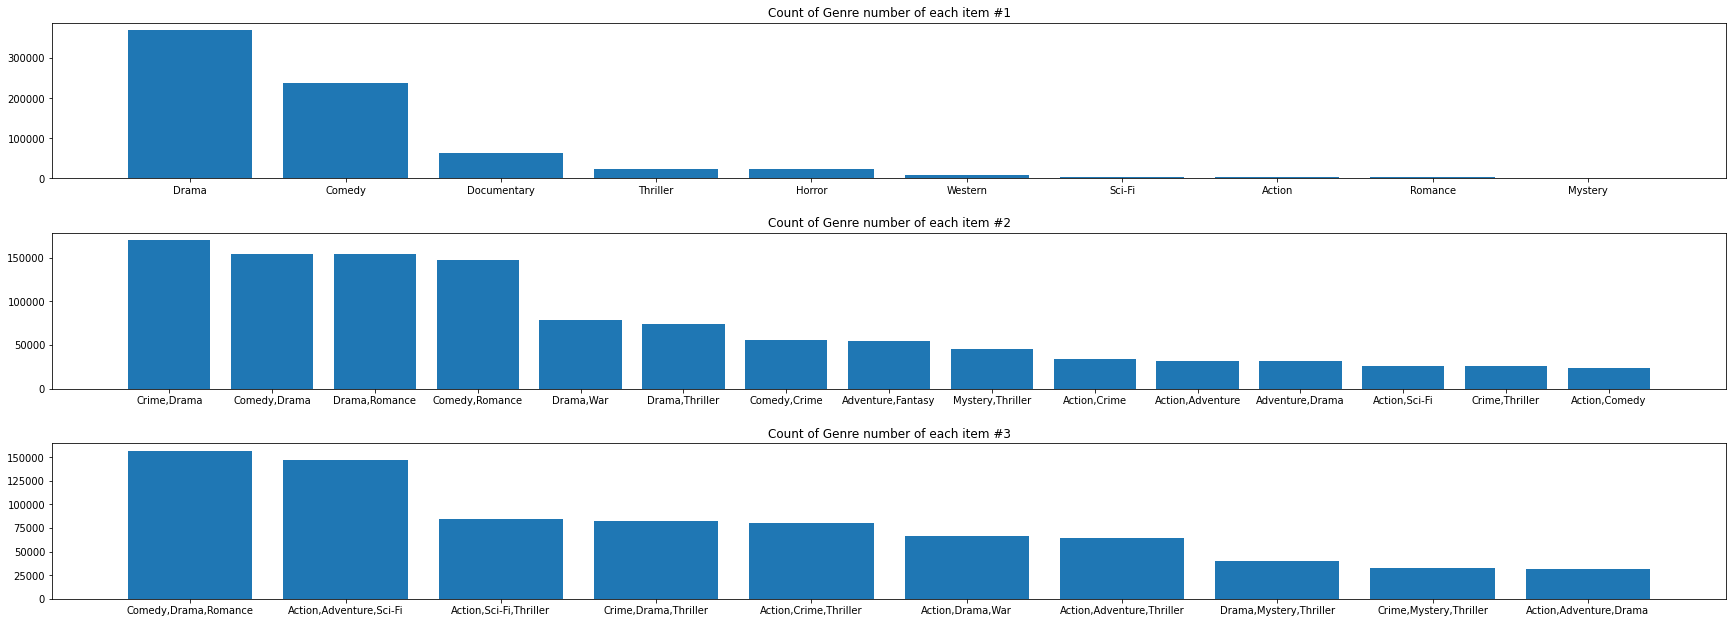

In [497]:
data1 = data[data['genre_num']==1]
data1 = data1.groupby('genre').count().sort_values(by='item', ascending=False).head(10)

data2 = data[data['genre_num']==2]
data2 = data2.groupby('genre').count().sort_values(by='item', ascending=False).head(15)

data3 = data[data['genre_num']==3]
data3 = data3.groupby('genre').count().sort_values(by='item', ascending=False).head(10)


fig, (axes1, axes2, axes3) = plt.subplots(3,1, figsize=(30,10))
axes1.bar(data1.index, data1.item)
axes1.set_title("Count of Genre number of each item #1")

axes2.bar(data2.index, data2.item)
axes2.set_title("Count of Genre number of each item #2")

axes3.bar(data3.index, data3.item)
axes3.set_title("Count of Genre number of each item #3")

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)


# 단일 장르에 대해서는 분포는 비슷
# 2개 장르에 대해서는, crime drama가 치고 올라오며 romance가 급감 ~ 적페 코,드,로의 비중이 실제 rating에서는 줄어듬
# 3개 장르에 대해서는, 액션어드벤쳐들이 치고 올라옴. ~ 단일로 사용되기 어려운 애들이 치고 올라옴 + 대중적

평균 시퀀스 : 440.09792729591834 /// 최소 시퀀스 : 0 /// 최대 시퀀스 : 3639 /// 분포 : 818.8238340430461 


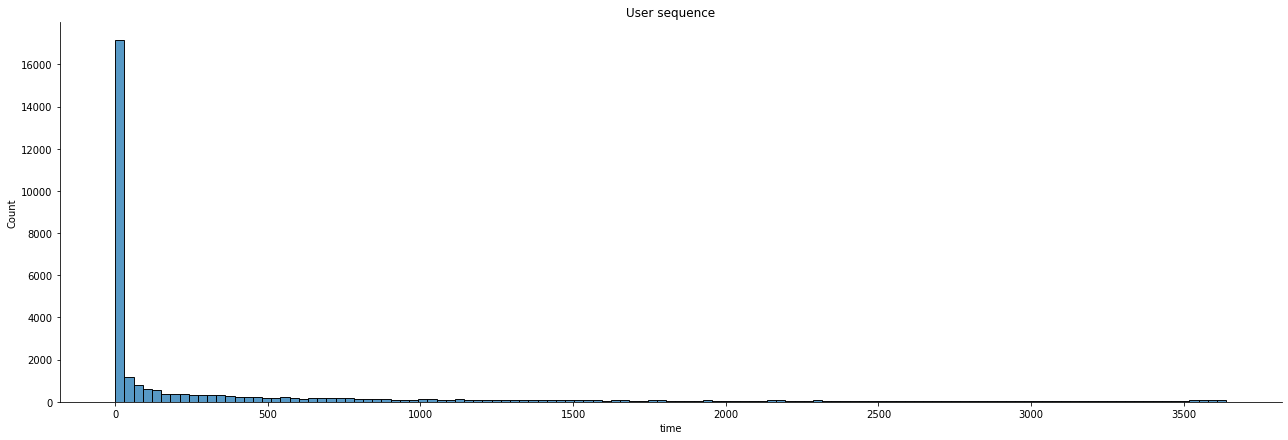

In [498]:
seq_max = data.groupby('user').time.max().reset_index()
seq_min = data.groupby('user').time.min().reset_index()
seq_max['time'] = seq_max['time'].apply(lambda x : datetime.fromtimestamp(x))
seq_min['time'] = seq_min['time'].apply(lambda x : datetime.fromtimestamp(x))
seq = seq_max - seq_min
seq['time'] = seq['time'].apply(lambda x : x.days)

sns.displot(seq.time, height = 6, aspect = 3).set(title='User sequence')
print("평균 시퀀스 : {} /// 최소 시퀀스 : {} /// 최대 시퀀스 : {} /// 분포 : {} ".format(seq.time.mean(),seq.time.min(),seq.time.max(),seq.time.std()))

# 각 유저별로, 최초 관측일과 마지막 관측일의 차이 확인 ~ 실제 rating관측이 10년간 이뤄진 것을 생각하면 상당히 유저별로 시퀀스가 짧다고 볼 수 있음

Text(0.5, 1.0, 'User sequence start to end')

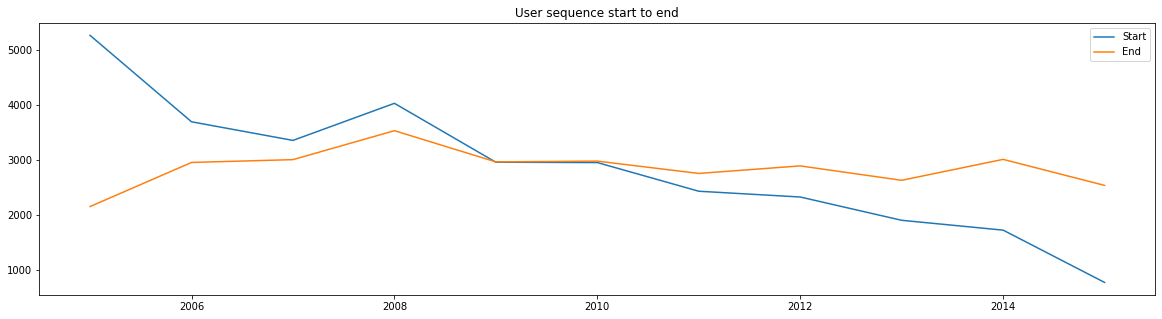

In [510]:
fig, axes1= plt.subplots(1,1,figsize=(20,5))

plt.plot(data.groupby('user').year.min().reset_index().groupby('year').count().index, data.groupby('user').year.min().reset_index().groupby('year').count().user, label='Start')
plt.plot(data.groupby('user').year.max().reset_index().groupby('year').count().index, data.groupby('user').year.max().reset_index().groupby('year').count().user, label='End')
plt.legend()
axes1.set_title('User sequence start to end')

# 관측 유입 유저는 점점 우하향하지만, 관측 이탈 유저는 시작부터 끝까지 flat해 전체적으로 마지막으로 갈 수록 줄어드는 경향

Text(0.5, 1.0, 'User watch and movie made')

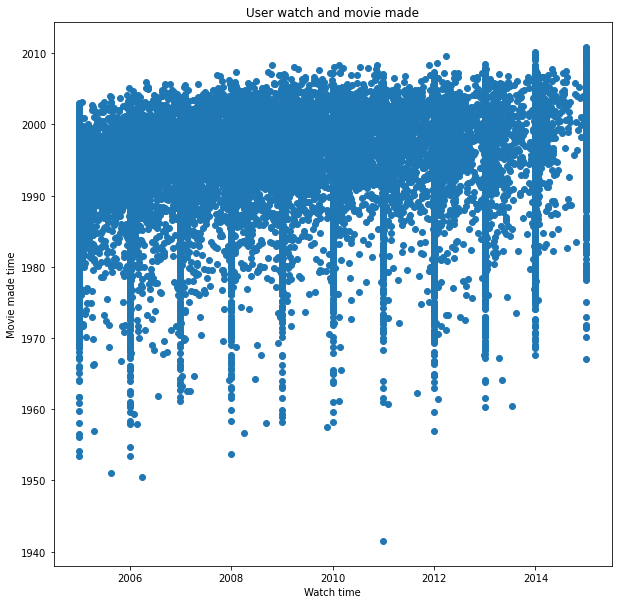

In [536]:
fig, axes1= plt.subplots(1,1,figsize=(10,10))

plt.scatter(data.groupby(['user']).mean()[['madeat','year']].reset_index().year,data.groupby(['user']).mean()[['madeat','year']].reset_index().madeat)
plt.xlabel('Watch time')
plt.ylabel('Movie made time')
axes1.set_title('User watch and movie made')

# 사전에, user의 관측시간과 해당 영화의 제작연도의 유의미한 관계가 있을 거라 생각 ~ 최신으로 갈수록 최신의 것을 본다 그렇기에 평균적으로 우상향하는 scatter가 찍힐수밖에 없다~ 왜냐 더 madeat이 크니까
# 그러나 실제로는 크게 유의성이 없어 보임. 즉 시퀀스 적으로 봤을 때, 의미가 없다는것

### Time lag 고려하고

In [538]:
rating = rating[rating['time_diff']>=120]

In [539]:
d_ = pd.merge(rating, title, on='item', how='left')
d_1 = pd.merge(d_, genre_new, on='item', how='left')
data = pd.merge(d_1, year, on='item', how='left')

# 우선 감독와 작가는 제외
data= data[['user', 'item', 'title','year_y','genre','year_x', 'month', 'hour','time_diff',]]
data.columns = ['user', 'item', 'title','madeat','genre','year', 'month', 'hour','time_diff']

In [540]:
data.loc[data['madeat'].isnull()].nunique()
# 현재 제작년도에 대해서만 결측 존재 ~ 이때 단 8개에 대해서만 결측 존재
#  그냥 각 year에 해당 결측치 채워주는 것으로 ~ 

data_ = pd.DataFrame({'item':[6987,   3310,   7243,   8511,  32898,   7065, 119145,   6988], 'year':[1920,1921,1916,1917,1902,1915,2015,1919]})
year = pd.concat([year,data_])
year.year = year.year.apply(lambda x : int(x))

In [541]:
d_ = pd.merge(rating, title, on='item', how='left')
d_1 = pd.merge(d_, genre_new, on='item', how='left')
data = pd.merge(d_1, year, on='item', how='left')

# 우선 감독와 작가는 제외
data= data[['user', 'item', 'title','year_y','genre','genre_num','time','year_x', 'month', 'hour','time_diff']]
data.columns = ['user', 'item', 'title','madeat','genre','genre_num','time','year', 'month', 'hour','time_diff']
# 재실행f


In [542]:
data.isnull().sum()

user         0
item         0
title        0
madeat       0
genre        0
genre_num    0
time         0
year         0
month        0
hour         0
time_diff    0
dtype: int64

Text(0.5, 1.0, 'Made at with real rating')

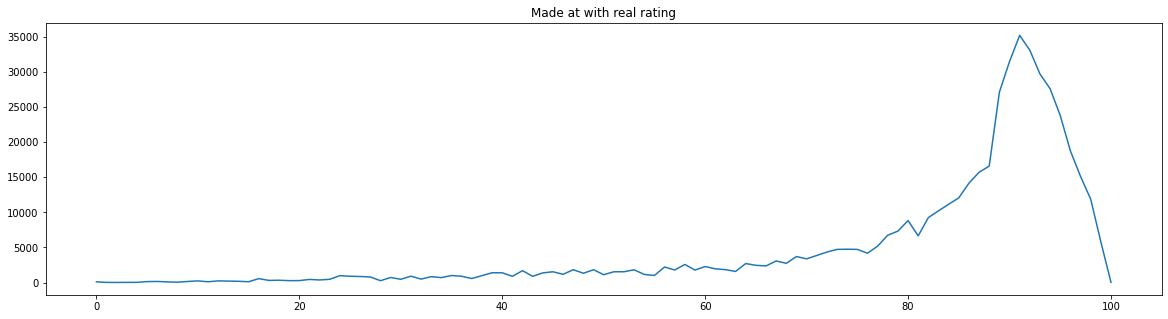

In [543]:
fig, axes1= plt.subplots(1,1,figsize=(20,5))
axes1.plot(data[['madeat']].value_counts().reset_index().sort_values(by='madeat').reset_index(drop=True)[0])
axes1.set_title('Made at with real rating')

# 실제 제작년도가 최근일수록 더더욱 보는 경향성이 있음
# rating의 구간이 2005-2015임을 감안했을 때, 당연한 결과 
# 영화의 제작년도는 1915부터 2015까지임을 감안했을 때, 당연한 결과 

# time lag 유의데이터에 대해서, 크게 차이 없음

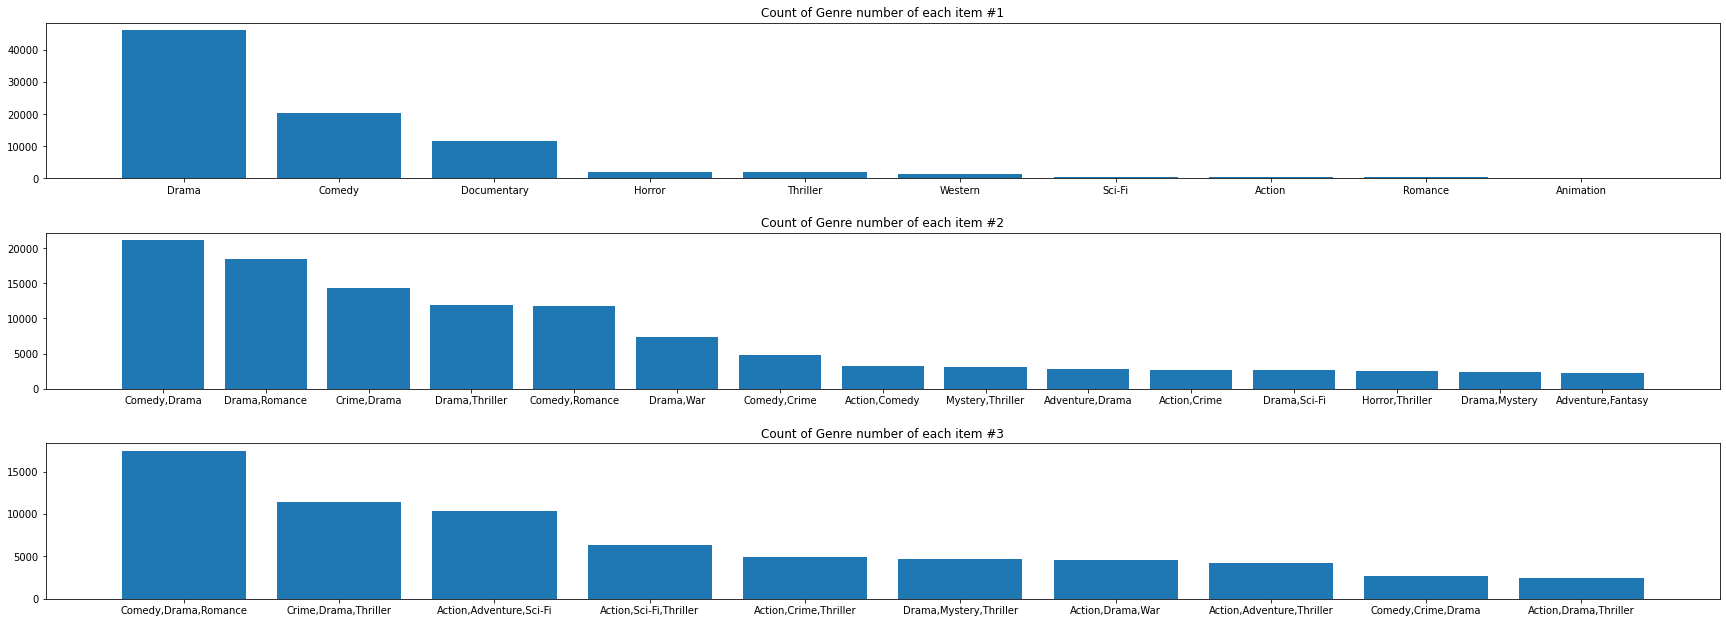

In [544]:
data1 = data[data['genre_num']==1]
data1 = data1.groupby('genre').count().sort_values(by='item', ascending=False).head(10)

data2 = data[data['genre_num']==2]
data2 = data2.groupby('genre').count().sort_values(by='item', ascending=False).head(15)

data3 = data[data['genre_num']==3]
data3 = data3.groupby('genre').count().sort_values(by='item', ascending=False).head(10)


fig, (axes1, axes2, axes3) = plt.subplots(3,1, figsize=(30,10))
axes1.bar(data1.index, data1.item)
axes1.set_title("Count of Genre number of each item #1")

axes2.bar(data2.index, data2.item)
axes2.set_title("Count of Genre number of each item #2")

axes3.bar(data3.index, data3.item)
axes3.set_title("Count of Genre number of each item #3")

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)


# 단일 장르에 대해서는 분포는 비슷
# 2개 장르에 대해서는, crime drama가 치고 올라오며 romance가 급감 ~ 적페 코,드,로의 비중이 실제 rating에서는 줄어듬
# 3개 장르에 대해서는, 액션어드벤쳐들이 치고 올라옴. ~ 단일로 사용되기 어려운 애들이 치고 올라옴 + 대중적

# time lag 유의 데이터에 대해서, 약간의 분포 차이가 보임

평균 시퀀스 : 512.1991568142241 /// 최소 시퀀스 : 0 /// 최대 시퀀스 : 3638 /// 분포 : 856.9683100371252 


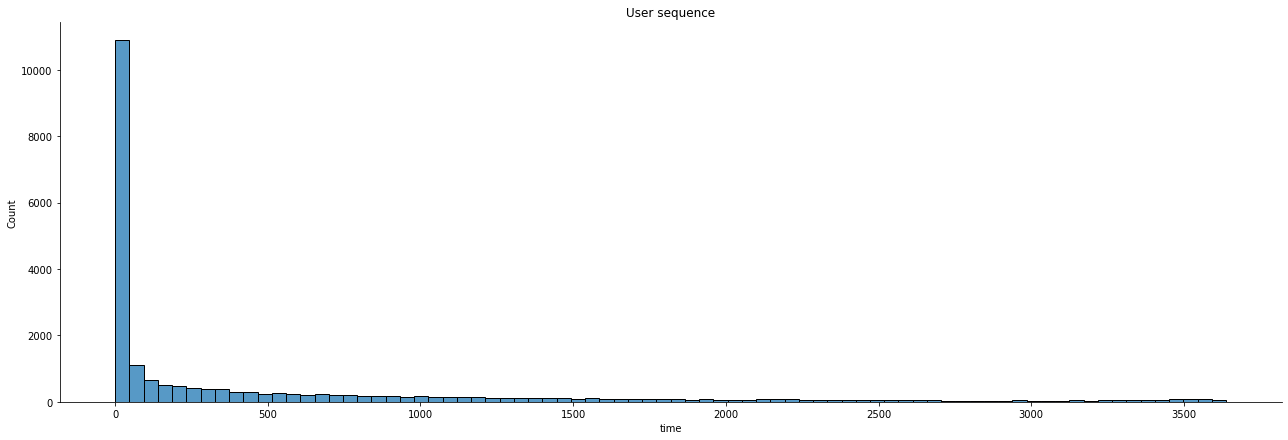

In [545]:
seq_max = data.groupby('user').time.max().reset_index()
seq_min = data.groupby('user').time.min().reset_index()
seq_max['time'] = seq_max['time'].apply(lambda x : datetime.fromtimestamp(x))
seq_min['time'] = seq_min['time'].apply(lambda x : datetime.fromtimestamp(x))
seq = seq_max - seq_min
seq['time'] = seq['time'].apply(lambda x : x.days)

sns.displot(seq.time, height = 6, aspect = 3).set(title='User sequence')
print("평균 시퀀스 : {} /// 최소 시퀀스 : {} /// 최대 시퀀스 : {} /// 분포 : {} ".format(seq.time.mean(),seq.time.min(),seq.time.max(),seq.time.std()))

# 각 유저별로, 최초 관측일과 마지막 관측일의 차이 확인 ~ 실제 rating관측이 10년간 이뤄진 것을 생각하면 상당히 유저별로 시퀀스가 짧다고 볼 수 있음

# time lag 유의 데이터에 대해서, 약간의 분포 차이가 보이나 차이가 유의하지는 않은 듯

Text(0.5, 1.0, 'User sequence start to end')

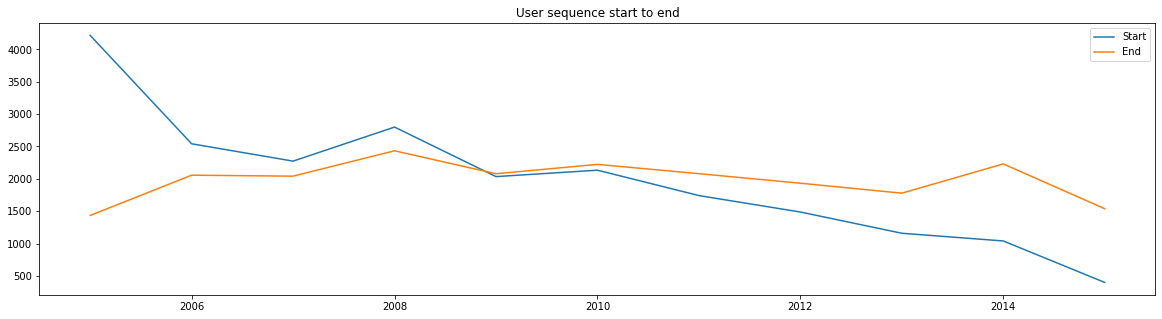

In [547]:
fig, axes1= plt.subplots(1,1,figsize=(20,5))

plt.plot(data.groupby('user').year.min().reset_index().groupby('year').count().index, data.groupby('user').year.min().reset_index().groupby('year').count().user, label='Start')
plt.plot(data.groupby('user').year.max().reset_index().groupby('year').count().index, data.groupby('user').year.max().reset_index().groupby('year').count().user, label='End')
plt.legend()
axes1.set_title('User sequence start to end')

# 관측 유입 유저는 점점 우하향하지만, 관측 이탈 유저는 시작부터 끝까지 flat해 전체적으로 마지막으로 갈 수록 줄어드는 경향

Text(0.5, 1.0, 'User watch and movie made')

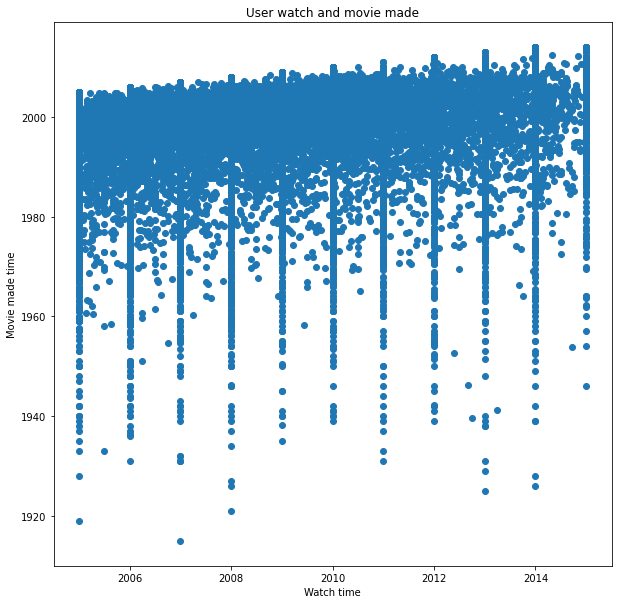

In [548]:
fig, axes1= plt.subplots(1,1,figsize=(10,10))

plt.scatter(data.groupby(['user']).mean()[['madeat','year']].reset_index().year,data.groupby(['user']).mean()[['madeat','year']].reset_index().madeat)
plt.xlabel('Watch time')
plt.ylabel('Movie made time')
axes1.set_title('User watch and movie made')

# 사전에, user의 관측시간과 해당 영화의 제작연도의 유의미한 관계가 있을 거라 생각 ~ 최신으로 갈수록 최신의 것을 본다 그렇기에 평균적으로 우상향하는 scatter가 찍힐수밖에 없다~ 왜냐 더 madeat이 크니까
# 그러나 실제로는 크게 유의성이 없어 보임. 즉 시퀀스 적으로 봤을 때, 의미가 없다는것